## 1: Import required packages & functions <a class="anchor" id="chapter1"></a>

In [82]:
print('Importing libraries')

%reset -f

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# clear all variables
for i in list(globals().keys()):
    if(i[0] != '_'):
        exec('del {}'.format(i))

#suppress future warnings -- not really a good idea 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# import required dependencies
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense
from numpy.random import seed
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, silhouette_score
import csv
import xlrd
import math
from matplotlib import figure
from IPython.display import FileLink, FileLinks
from IPython.display import set_matplotlib_formats
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict, StratifiedKFold 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#import utils
#from utils import encode_features_v3

set_matplotlib_formats('png', 'pdf') # uses vector figures in pdf exports --
plt.style.use('seaborn-pastel')

# create a folder
def create_folder(folder):
    import os     
    try: 
        os.mkdir(folder) 
    except FileExistsError:
        print("Directory [ %s ] already exists"%folder)

Importing libraries


## 2: Cluster Heatmap For Top Neuropathology & Clinical Features  <a class="anchor" id="chapter2"></a>

This is to show how the top 8 neuropathology and 10 associated clinical features with the three clusters performs in terms of the misclassified cases

In [83]:
new_balanced_no_AB = pd.read_csv('Classification/new_balanced_no_AB.csv')
clinical_features = pd.read_csv('../data/clinical signature features.csv',header = 0) # read clinical dataset
clinical_with_memberships = pd.read_csv('Classification/clinical_with_memberships.csv',header = 0) # read clinical dataset

# This is for top 8 neuropathology and 10 selected cilincal features
new_balanced_no_AB = new_balanced_no_AB.applymap(np.int64).copy()
selected_patho_clinical = new_balanced_no_AB.iloc[:,0:9].merge(clinical_with_memberships[clinical_features.feature], on=['Case'])

selected_patho_clinical

,Case,BraakStage,BrainNetStage,CAAType,CAAMeningeal,ThalStage,CAAParenc,CAATotalSev,MTSPETSA,age,tanglest,gap,brain weight,interval,gapd,lossh,amyparf,losss,lewys
0,27491,4,3,2,7,5,6,13,1,91.0,No,0.087611,-0.046747,0.087611,32.0,Mild,No,Sev,Sev
1,17,2,1,0,0,2,0,0,0,93.0,No,0.856947,-0.933614,0.856947,313.0,No,No,Mod,No
2,6909,2,2,0,0,0,0,0,1,86.0,No,1.363450,0.396687,1.363450,498.0,Mild,No,No,No
3,4,3,3,0,0,3,0,0,0,85.0,Mild,0.963723,-0.032501,0.963723,352.0,No,No,Mild,No
4,65,3,2,0,0,0,0,0,1,99.0,Mild,1.675565,-0.750937,1.675565,612.0,No,No,Mild,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,73,4,4,1,5,3,4,9,1,94.0,Mild,0.936345,1.564024,0.936345,342.0,Mild,No,Mild,No
110,114,4,3,1,9,3,7,16,1,99.0,Mild,2.442163,0.765762,2.442163,892.0,No,Mild,Mild,No
111,10596,4,4,1,9,5,8,17,0,97.0,Sev,1.196441,0.685936,1.196441,437.0,Mild,Mild,No,No
112,24,4,3,1,8,4,4,12,0,76.0,Mild,1.908282,0.127152,1.908282,697.0,No,No,Mild,No


In [84]:
new_balanced_no_AB = pd.read_csv('Classification/new_balanced_no_AB.csv')
selected_patho_clinical["dem_nver4"] = new_balanced_no_AB.dem_nver4

selected_patho_clinical.replace({'No':0, 'Mild':1, 'Mod':2, 'Sev':3}, inplace=True)
selected_patho_clinical.replace({'Yes':1}, inplace=True)

# drop case features
selected_patho_clinical = selected_patho_clinical.drop(columns=['Case'])

numeric_cols=['age', 'gap', 'brain weight', 'gapd', 'interval']                     # numeric features
selected_patho_clinical[numeric_cols]=MinMaxScaler().fit_transform(selected_patho_clinical[numeric_cols])  # transform

selected_patho_clinical

TypeError: Cannot compare types 'ndarray(dtype=float64)' and 'str'

## 3: Function to predict for all classifiers   <a class="anchor" id="chapter3"></a>

In [85]:

dataset = pd.DataFrame(selected_patho_clinical).copy()
X = dataset.iloc[:,:-1]
y = np.ravel(dataset.iloc[:,-1])

In [86]:
logreg_fscore_mean=[]; logreg_precision_mean=[]; logreg_recall_mean=[]; logreg_balanced_acc_mean=[]
logreg_sens_mean=[]; logreg_spec_mean=[]; logreg_acc_mean=[]; 
logreg_average_precision_mean=[]; logreg_auc_mean=[];

dt_fscore_mean=[]; dt_precision_mean=[]; dt_recall_mean=[]; dt_balanced_acc_mean=[]
dt_sens_mean=[]; dt_spec_mean=[]; dt_acc_mean=[]; 
dt_average_precision_mean=[]; dt_auc_mean=[]

knn_fscore_mean=[]; knn_precision_mean=[]; knn_recall_mean=[]; knn_balanced_acc_mean=[]
knn_sens_mean=[]; knn_spec_mean=[]; knn_acc_mean=[]; 
knn_average_precision_mean=[]; knn_auc_mean=[]

lda_fscore_mean=[]; lda_precision_mean=[]; lda_recall_mean=[]; lda_balanced_acc_mean=[]
lda_sens_mean=[]; lda_spec_mean=[]; lda_acc_mean=[]; 
lda_average_precision_mean=[]; lda_auc_mean=[]

gnb_fscore_mean=[]; gnb_precision_mean=[]; gnb_recall_mean=[]; gnb_balanced_acc_mean=[]
gnb_sens_mean=[]; gnb_spec_mean=[]; gnb_acc_mean=[]; 
gnb_average_precision_mean=[]; gnb_auc_mean=[]

svm_rbf_fscore_mean=[]; svm_rbf_precision_mean=[]; svm_rbf_recall_mean=[]; svm_rbf_balanced_acc_mean=[] 
svm_rbf_sens_mean=[]; svm_rbf_spec_mean=[]; svm_rbf_acc_mean=[]; 
svm_rbf_average_precision_mean=[]; svm_rbf_auc_mean=[]

svm_linear_fscore_mean=[]; svm_linear_precision_mean=[]; svm_linear_recall_mean=[]; svm_linear_balanced_acc_mean=[] 
svm_linear_sens_mean=[]; svm_linear_spec_mean=[]; svm_linear_acc_mean=[];
svm_linear_average_precision_mean=[]; svm_linear_auc_mean=[];


In [87]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict, StratifiedKFold 

# loocv to manually evaluate the performance of a random forest classifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

# read dataset
X = dataset.iloc[:,:-1]
y = np.ravel(dataset.iloc[:,-1])

all_y_pred = pd.DataFrame()

logreg_y_pred = pd.DataFrame(); dt_y_pred = pd.DataFrame(); knn_y_pred = pd.DataFrame(); lda_y_pred = pd.DataFrame();
gnb_y_pred = pd.DataFrame(); svm_rbf_y_pred = pd.DataFrame(); svm_linear_y_pred = pd.DataFrame();

# create loocv procedure
cv = LeaveOneOut()
print("subset:")
for num in range(0,len(X.columns)):
    print(num," \b", end="")
    
    #get data and target
    X_subset = X.iloc[:,num::-1]
    
    # feature scaling
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_subset)

    logreg = LogisticRegression(random_state = 220)
    dt = DecisionTreeClassifier(random_state = 220)
    knn = KNeighborsClassifier()
    lda = LinearDiscriminantAnalysis()
    gnb = GaussianNB()
    svm_rbf = SVC(kernel='rbf', random_state = 220)
    svm_linear = SVC(kernel='linear', random_state = 220)
    
    # calculate cross validation score for each of the fitted models 
    for model in ['logreg', 'dt', 'knn', 'lda', 'gnb', 'svm_rbf', 'svm_linear']:   
        # enumerate splits
        y_true, y_pred = list(), list()
        for train_ix, test_ix in cv.split(X_scaled):
            # split data
            X_train, X_test = X_scaled[train_ix, :], X_scaled[test_ix, :]
            y_train, y_test = y[train_ix], y[test_ix]
            # fit model
            exec("%s"%model+".fit(X_train, y_train)")
            # evaluate model
            exec("yhat = %s"%model+".predict(X_test)")
            # store
            y_true.append(y_test[0])
            y_pred.append(yhat[0])
        exec("%s"%model+"_y_pred['%s"%model+"_%d"%(num+1)+"'] = y_pred")
        
        exec("%s"%model+"_fscore_mean.append(f1_score(y, y_pred))") 
        exec("%s"%model+"_precision_mean.append(precision_score(y, y_pred))")
        exec("%s"%model+"_recall_mean.append(recall_score(y, y_pred))")
        exec("%s"%model+"_balanced_acc_mean.append(balanced_accuracy_score(y, y_pred))")
        exec("%s"%model+"_acc_mean.append(accuracy_score(y, y_pred))")
        exec("%s"%model+"_average_precision_mean.append(average_precision_score(y, y_pred))")
#         exec("sens, spec, auc_value = perf_eval(y, y_pred)")
#         exec("%s"%model+"_sens_mean.append(sens)") 
#         exec("%s"%model+"_spec_mean.append(spec)") 
#         exec("%s"%model+"_auc_mean.append(auc_value)")

subset:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

## 4: Binary Table Matrix   <a class="anchor" id="chapter4"></a>

In [88]:
y_pred = pd.DataFrame()
all_y_pred = pd.DataFrame()
for model in ['logreg', 'dt', 'knn', 'lda', 'gnb', 'svm_rbf', 'svm_linear']:
    exec("all_y_pred = pd.concat([all_y_pred, %s"%model+"_y_pred], axis=1)")

In [89]:
#------------------ FUNCTION -----------------------#
def binary_table(y_pred, y_true):
    data = pd.DataFrame(y_pred)
    data['y_true'] = y_true['dem_nver4']

    cond_1 = (data.iloc[:,1] == 1) & (data.iloc[:,0] == 1)
    cond_2 = (data.iloc[:,1] == 0) & (data.iloc[:,0] == 0)
    cond_3 = (data.iloc[:,1] == 1) & (data.iloc[:,0] != 1)
    cond_4 = (data.iloc[:,1] == 0) & (data.iloc[:,0] != 0)

    conditions = [cond_1,cond_2,cond_3,cond_4]
    choices = [0,0,1,-1]

    data.drop('y_true', axis=1, inplace=True)
    data.iloc[:,0] = np.select(conditions, choices, default='null')
    return data
#---------------------------------------------------#

X = pd.DataFrame(dataset.iloc[:,:-1])
y = pd.DataFrame(dataset.dem_nver4)

all_binary_result = pd.DataFrame(y)

for classifier in ['logreg','dt','knn','lda','gnb','svm_rbf','svm_linear']:
    for subset in np.arange(1, len(X.columns)+1, 1):
        exec("%s"%classifier+"_%s"%subset+" = binary_table(all_y_pred['%s"%classifier+"_%s"%subset+"'],y)")
        exec("all_binary_result['%s"%classifier+"_%s"%subset+"'] = %s"%classifier+"_%s"%subset)

In [90]:
all_binary_result

,dem_nver4,logreg_1,logreg_2,logreg_3,logreg_4,logreg_5,logreg_6,logreg_7,logreg_8,logreg_9,...,svm_linear_10,svm_linear_11,svm_linear_12,svm_linear_13,svm_linear_14,svm_linear_15,svm_linear_16,svm_linear_17,svm_linear_18,svm_linear_19
0,1,1,1,1,1,1,1,1,1,0,...,0,1,1,0,0,0,0,0,0,0
1,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,0,0
3,0,-1,-1,-1,-1,0,-1,-1,-1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0


In [91]:
from pandas.plotting import table 
all_binary_result.drop('dem_nver4', axis=1,inplace=True)

aa = all_binary_result.style.applymap(lambda x: "background-color: red" if x == '-1' else "background-color: blue" if x == '1' else "background-color: white")

all_binary_result = all_binary_result.astype(int)
aaa_test = all_binary_result

In [92]:
aa

## 5: Hierarchical Clustering   <a class="anchor" id="chapter5"></a>

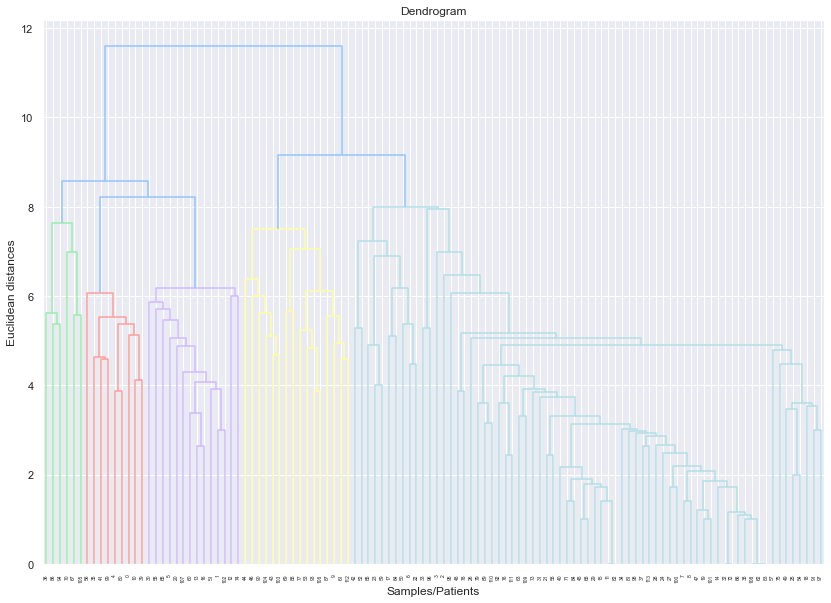

In [93]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='average')

y_hc=hc.fit(all_binary_result)

#get rows' clusters
membership = hc.labels_
binary_clusters = pd.DataFrame(all_binary_result).copy()
binary_clusters['clusters'] = membership


fig=plt.figure(figsize=(14, 10)) 
dendrogram = sch.dendrogram(sch.linkage(all_binary_result, method  = "average"))
plt.title('Dendrogram')
plt.xlabel('Samples/Patients')
plt.ylabel('Euclidean distances')
plt.axhline(y=14, color='r', linestyle='--')
plt.show()

In [94]:
import seaborn as sns; sns.set(color_codes=True)
heatmap_binary = all_binary_result
heatmap_binary.columns = pd.MultiIndex.from_product([['logreg', 'dt', 'knn', 'lda', 'gnb', 'svm_rbf', 'svm_linear'], 
                                                     np.arange(1, len(X.columns)+1, 1)], 
                                                   names=['Classifiers', 'Subsets of Features'])
# ### For tree colors
clusters = binary_clusters.pop("clusters")

#### [0 - FN - 15] [1 - FP - 23] [2 - TP&TN - 76]

In [95]:
clusters.value_counts()

1    69
0    29
2    16
Name: clusters, dtype: int64

## 6: Cluster Heatmap  <a class="anchor" id="chapter6"></a>

/Users/mohammed/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


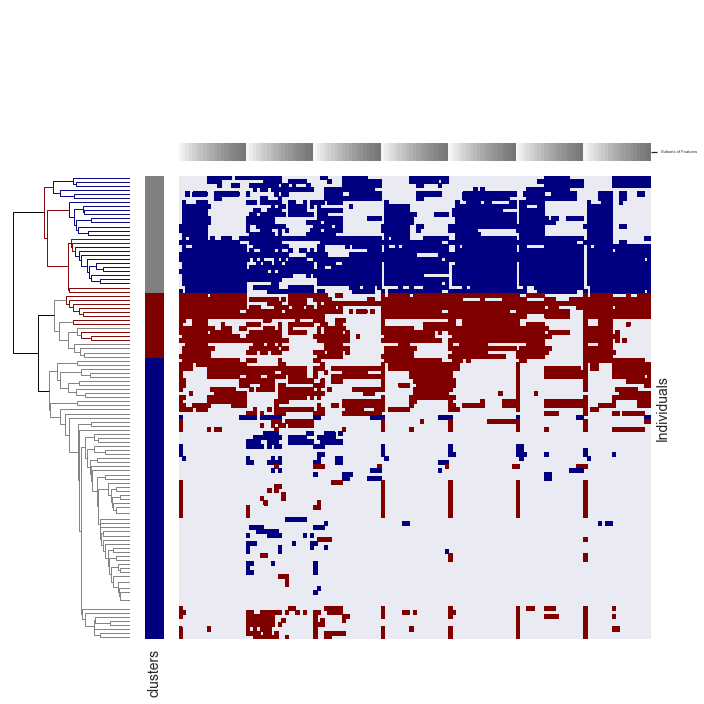

In [96]:
from matplotlib.colors import LinearSegmentedColormap
#### classifiers level
classi_labels = heatmap_binary.columns.get_level_values("Classifiers")
classi_pal = sns.cubehelix_palette(classi_labels.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
classi_lut = dict(zip(map(str, classi_labels.unique()), classi_pal))

#### Create index using the columns for classifiers
classi_colors = pd.Series(classi_labels, index=heatmap_binary.columns).map(classi_lut)

#### subsets level
subset_labels = heatmap_binary.columns.get_level_values("Subsets of Features")
subset_pal = sns.cubehelix_palette(subset_labels.unique().size, as_cmap=True, hue=0, start=0.3, light=1.0, dark=0.0,rot=-10.0, gamma=10.0)

#### Create index using the columns for subsets
subset_colors = pd.Series(subset_labels, index=heatmap_binary.columns).map(subset_pal)

# classi_subset_colors = pd.DataFrame(subset_colors)
classi_subset_colors = pd.DataFrame(subset_colors)#pd.DataFrame(classi_colors).join(pd.DataFrame(subset_colors))

### decoding colors for heatmap and dendograms
red=(0.5, 0.0, 0.0, 1.0)
blue=(0.0, 0.0, 0.5, 1.0)
black=(0.0, 0.0, 0.0, 0.0)
white=(1,1,1,1)
grey=(0.5, 0.5, 0.5, 1.0)

### tree clusters colors

clusters_lut = dict(zip(clusters.unique(), [grey, blue, red]))
row_colors = clusters.map(clusters_lut)

''''''''''''''''''
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=4)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels

plt.rcParams['savefig.facecolor']='white'

myColors = (red,black, blue)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))


# color bar keyword arguments
cbar_kws = {"shrink":1,
            'ticks': ['f',0,-1], # set ticks of color bar
            'label':'Color Bar'}

g = sns.clustermap(all_binary_result,
                    method= 'average',
                    metric= "euclidean",
                    col_cluster=False,
                    row_cluster=True,
                    col_colors = classi_subset_colors,
                    row_colors=row_colors,
                    cmap=cmap,
                    tree_kws=dict(linewidths=0.95, colors=([blue]*22+[red]*14+[grey]*75+[(0,0,0,1)]*2)),
                    linewidths=0.0,
                   rasterized=True,
                   xticklabels=False, 
                   yticklabels=False, 
                   center=0) 


# ### tree leaves colors
# n_leaves = len(g.dendrogram_row.linkage)+1
# n0_ndx = len(g.dendrogram_row.linkage) - 1
# n1_ndx = int(g.dendrogram_row.linkage[n0_ndx][0])-n_leaves
# n2_ndx = int(g.dendrogram_row.linkage[n0_ndx][1])-n_leaves
# n21_ndx = int(g.dendrogram_row.linkage[n2_ndx][0])-n_leaves
# n22_ndx = int(g.dendrogram_row.linkage[n2_ndx][1])-n_leaves

# n1 = int(g.dendrogram_row.linkage[n1_ndx][3])-1
# n21 = int(g.dendrogram_row.linkage[n22_ndx][3])-1
# n22 = int(g.dendrogram_row.linkage[n21_ndx][3])-1


g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(True)
g.ax_col_dendrogram.set_visible(True)

ax = g.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("Individuals")
plt.tight_layout()

plt.show()

g.savefig('Figures/top patho + clinical signature clustermap.pdf',dpi=300, bbox_inches="tight")
g.savefig('Figures/top patho + clinical signature clustermap.png',dpi=300, bbox_inches="tight")


## 7: Held-out 32 cases for top 8 Neuropathology & Clinical Signatures  <a class="anchor" id="chapter7"></a>

In [97]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score

def perf_eval(actual, predicted):
    # calculate confusion matrix
    cm=confusion_matrix(actual, predicted)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    # calculate perf
    sens=(TP/(TP+FN))
    spec=(TN/(TN+FP))
    acc=((TP+TN)/(TP+FP+TN+FN))

    precision = TP / (TP+FP)
    recall    = TP / (TP+FN)

    F1_score = 2 * (precision * recall) / (precision + recall)
    
    fpr, tpr, thresholds = metrics.roc_curve(actual, predicted)
    auc_value = metrics.auc(fpr, tpr)
    
    return sens, spec, auc_value

In [98]:
logreg_fscore_mean=[]; logreg_precision_mean=[]; logreg_recall_mean=[]; logreg_balanced_acc_mean=[]
logreg_sens_mean=[]; logreg_spec_mean=[]; logreg_acc_mean=[]; 
logreg_average_precision_mean=[]; logreg_auc_mean=[];

dt_fscore_mean=[]; dt_precision_mean=[]; dt_recall_mean=[]; dt_balanced_acc_mean=[]
dt_sens_mean=[]; dt_spec_mean=[]; dt_acc_mean=[]; 
dt_average_precision_mean=[]; dt_auc_mean=[]

knn_fscore_mean=[]; knn_precision_mean=[]; knn_recall_mean=[]; knn_balanced_acc_mean=[]
knn_sens_mean=[]; knn_spec_mean=[]; knn_acc_mean=[]; 
knn_average_precision_mean=[]; knn_auc_mean=[]

lda_fscore_mean=[]; lda_precision_mean=[]; lda_recall_mean=[]; lda_balanced_acc_mean=[]
lda_sens_mean=[]; lda_spec_mean=[]; lda_acc_mean=[]; 
lda_average_precision_mean=[]; lda_auc_mean=[]

gnb_fscore_mean=[]; gnb_precision_mean=[]; gnb_recall_mean=[]; gnb_balanced_acc_mean=[]
gnb_sens_mean=[]; gnb_spec_mean=[]; gnb_acc_mean=[]; 
gnb_average_precision_mean=[]; gnb_auc_mean=[]

svm_rbf_fscore_mean=[]; svm_rbf_precision_mean=[]; svm_rbf_recall_mean=[]; svm_rbf_balanced_acc_mean=[] 
svm_rbf_sens_mean=[]; svm_rbf_spec_mean=[]; svm_rbf_acc_mean=[]; 
svm_rbf_average_precision_mean=[]; svm_rbf_auc_mean=[]

svm_linear_fscore_mean=[]; svm_linear_precision_mean=[]; svm_linear_recall_mean=[]; svm_linear_balanced_acc_mean=[] 
svm_linear_sens_mean=[]; svm_linear_spec_mean=[]; svm_linear_acc_mean=[];
svm_linear_average_precision_mean=[]; svm_linear_auc_mean=[];


In [99]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict, StratifiedKFold 


# loocv to manually evaluate the performance of a random forest classifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report


# read dataset for top 8 neuropathogy features
dataset = pd.read_csv('Classification/new_balanced_no_AB.csv');
dataset.drop(labels=['Case'], axis=1, inplace=True) 
X = dataset.iloc[:,0:8]
y = np.ravel(dataset.iloc[:,-1])

#read dataset for selected clinical signature features
heldout_data = pd.read_csv('Classification/not_selected_no_AB.csv');
heldout_data.dem_nver4.replace({'No dementia':0, 'Dementia':1}, inplace=True)
X_heldout = heldout_data.iloc[:,0:8]
y_heldout = np.ravel(heldout_data.iloc[:,-1])

                    
# feature scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
heldout_scaled = scaler.fit_transform(X_heldout)


#creat models
logreg = LogisticRegression(random_state = 220)
dt = DecisionTreeClassifier(random_state = 220)
knn = KNeighborsClassifier()
lda = LinearDiscriminantAnalysis()
gnb = GaussianNB()
svm_rbf = SVC(kernel='rbf', random_state = 220)
svm_linear = SVC(kernel='linear', random_state = 220)


measures = pd.DataFrame(['F1-score', 'Precision', 'Recall', 'Accuracy'])

# calculate cross validation score for each of the fitted models 
for model in ['logreg', 'dt', 'knn', 'lda', 'gnb', 'svm_rbf', 'svm_linear']:   

    exec("%s"%model+".fit(X_scaled, y)")
    exec("yhat = %s"%model+".predict(heldout_scaled)")
        
    exec("%s"%model+"_fscore_mean.append(f1_score(y_heldout, yhat))") 
    exec("%s"%model+"_precision_mean.append(precision_score(y_heldout, yhat))")
    exec("%s"%model+"_recall_mean.append(recall_score(y_heldout, yhat))")
    exec("%s"%model+"_balanced_acc_mean.append(balanced_accuracy_score(y_heldout, yhat))")
    exec("%s"%model+"_acc_mean.append(accuracy_score(y_heldout, yhat))")
    exec("%s"%model+"_average_precision_mean.append(average_precision_score(y_heldout, yhat))")
    
    exec("sens, spec, auc_value = perf_eval(y_heldout, yhat)")
    exec("%s"%model+"_sens_mean.append(sens)")
    exec("%s"%model+"_spec_mean.append(spec)")
#     exec("%s"%model+".append(auc_value)")
       
        

/Users/mohammed/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Users/mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/Users/mohammed/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/mohammed/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Users/mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/Users/mohammed/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarni

In [100]:
logreg_sens_mean

[0.6875]

In [101]:
dt_sens_mean

[0.625]

In [102]:
knn_sens_mean

[0.65625]

In [103]:
lda_sens_mean

[0.625]

In [104]:
gnb_sens_mean

[0.65625]

In [105]:
svm_rbf_sens_mean

[0.59375]

In [106]:
svm_linear_sens_mean

[0.625]